In [1]:
import numpy as np
import torch
import GPy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessClassifier
from visualize import *
from calibration import *
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
%matplotlib inline

NUM_BINS = 10
N = 1000 # takes value from 1 to 10000
NUM_CLASSES =  100
NUM_CLASSES_PLOT = 4
NUM_COL = 2
METHOD_NAME = "binary_gp"

In [2]:
# Load prediction from ResNet on CIFAR100 test data, which contains 10,000 images. 
# https://github.com/rloganiv/pytorch-classification/blob/master/predict.py
# data: a numpy array of size 10,000 * 101. For each row, the first entry is the true label,
#       following by softmax of output logits of this image for each class.
data = np.genfromtxt("data/cifar100_predictions_dropout.txt")[0:N,:]# 10000*101

In [3]:
p = data[:,1:]
Y_predict = np.argmax(p, axis=1)
Y_true = data[:,0]

# Fit GPC to each class


Learned kernel: RBF(length_scale=0.05)

Learned kernel: RBF(length_scale=0.05)

Learned kernel: RBF(length_scale=0.05)

Learned kernel: RBF(length_scale=0.101)

Learned kernel: RBF(length_scale=0.05) + 5.09**2 * RBF(length_scale=0.747)

Learned kernel: RBF(length_scale=0.05) + 6.03**2 * RBF(length_scale=0.755)

Learned kernel: RBF(length_scale=0.05) + 6.72**2 * RBF(length_scale=0.0226)

Learned kernel: RBF(length_scale=0.0619) + 4.85**2 * RBF(length_scale=0.913)

Learned kernel: RBF(length_scale=0.05) + 5.19**2 * RBF(length_scale=0.892) + 3.66**2 * DotProduct(sigma_0=0.00134)

Learned kernel: RBF(length_scale=0.05) + 5.38**2 * RBF(length_scale=1.24) + 8.9**2 * DotProduct(sigma_0=0.0034)

Learned kernel: RBF(length_scale=0.05) + 6.72**2 * RBF(length_scale=0.0226) + 0.0035**2 * DotProduct(sigma_0=0.00909)

Learned kernel: RBF(length_scale=0.0623) + 4.77**2 * RBF(length_scale=1.37) + 5.33**2 * DotProduct(sigma_0=0.000605)


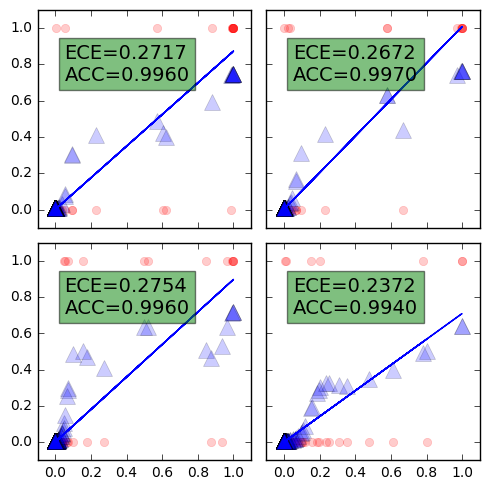

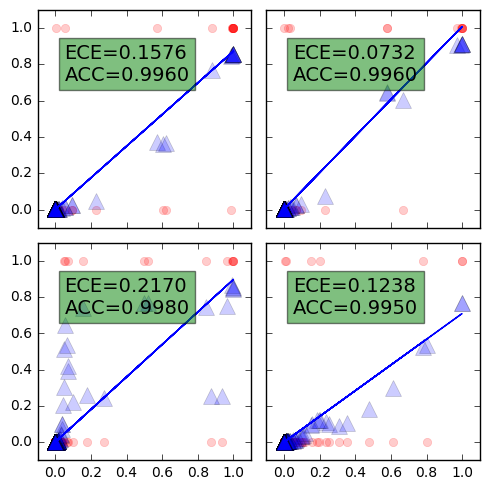

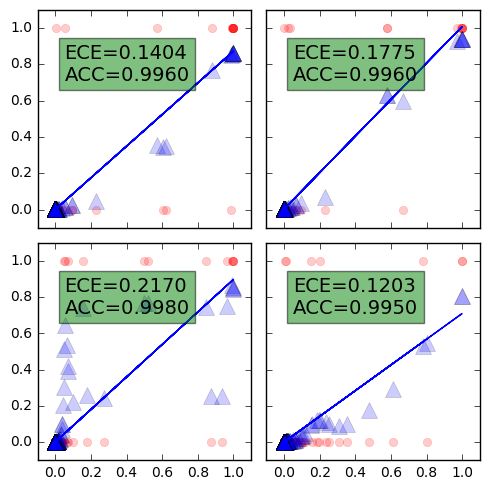

In [4]:
# GPC with SKlearn
KERNELS = [RBF(0.1, (0.05, 1)), 
           RBF(0.1, (0.05, 1)) + 10**2 * RBF(1), 
           RBF(0.1, (0.05, 1)) + 10**2 * RBF(1) + 100.0 * DotProduct(sigma_0=1.0)]
for kernel in KERNELS:
    f, ax = plt.subplots(NUM_CLASSES_PLOT/NUM_COL, NUM_COL, sharex='col', sharey='row')
    f.set_figheight(5)
    f.set_figwidth(5)
    for K in range(NUM_CLASSES_PLOT):
        ax[K/NUM_COL, K%NUM_COL] = gpc_sklearn(ax[K/NUM_COL, K%NUM_COL],
                                                 p[:,K],
                                                 np.array((Y_true == K)) * 1,
                                                 kernel)
    f.tight_layout()
    #f.savefig("figures/%s/reliability_per_class.png" % METHOD_NAME)
    #f.savefig("figures/%s/reliability_per_class.eps" % METHOD_NAME, format='eps',dpi=1000)
    #plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')

In [ ]:
def gpc_gpy(ax, x, y, kernel=None):
    """
    Implemented with GPy. The latent function values modeled by GP are squashed through the probit function. 
    We interleave runs of EP with optimization of the parameters using gradient descent methods. 
    EP is a method for fitting a Gaussian to the posterior, p(f|y) of the latent (hidden) function, given the data. 
    Whilst the parameters are being optimized, the EP approximation (the parameters of the EP factors) is fixed.
    
    INPUT:
        ax: an Axes object
        x: (N, ) np.array
        y: (N, ) np.array
        kernel: A GPy.kern object or None.
    OUTPUT:
        ax: an Axes object
    """
    # Fit GaussianProcessClassification and LinearRegression models
    if kernel == None:
        m = GPy.models.GPClassification(X=x[:, np.newaxis],Y=y[:, np.newaxis])
    else:
        m = GPy.core.GP(
            X=x[:, np.newaxis],
            Y=y[:, np.newaxis],
            kernel=kernel, 
            inference_method=GPy.inference.latent_function_inference.expectation_propagation.EP(),
            likelihood=GPy.likelihoods.Bernoulli()
        )
    print m, '\n'
    for i in range(1):
        m.optimize('bfgs', max_iters=100) #first runs EP and then optimizes the kernel parameters
        print 'iteration:', i,
        print m
        print ""
    y_ = m.predict(x[:, np.newaxis])[0][:,0]
    
    lr = LinearRegression()
    lr.fit(x[:, np.newaxis], y)  # x needs to be 2d for LinearRegression
    
    # Plot data, p(y=1|x) in GPC, linear regression
    #m.plot()
    ax.plot(x, y, 'r.', markersize=12, alpha = 0.2)
    ax.plot(x, y_, 'b^', markersize=12, alpha = 0.2)
    ax.plot(x, lr.predict(x[:, np.newaxis]), 'b-')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    
    # Plot 
    
    # compute ece and acc after calibration
    ece = EceEval(np.array([1-y_, y_]).T , y, num_bins = 20)
    y_predict = y_ > 0.5
    acc = (y_predict == y).mean()
    
    ax.text(0.05, 0.8, 'ECE=%.4f\nACC=%.4f'% (ece, acc), size=14, ha='left', va='center',
            bbox={'facecolor':'green', 'alpha':0.5, 'pad':4})
    
    return ax

In [ ]:
# GPC with GPy
KERNELS = [GPy.kern.RBF(1,variance=5.,lengthscale=0.1) + GPy.kern.Linear(1), None]
for kernel in KERNELS:
    f, ax = plt.subplots(NUM_CLASSES_PLOT/NUM_COL, NUM_COL, sharex='col', sharey='row')
    f.set_figheight(5)
    f.set_figwidth(5)
    
    for K in range(NUM_CLASSES_PLOT):
        ax[K/NUM_COL, K%NUM_COL] = gpc_gpy(ax[K/NUM_COL, K%NUM_COL],
                                                 p[:,K],
                                                 np.array((Y_true == K)) * 1,
                                                 kernel)
    f.tight_layout()
    #f.savefig("figures/%s/reliability_per_class.png" % METHOD_NAME)
    #f.savefig("figures/%s/reliability_per_class.eps" % METHOD_NAME, format='eps',dpi=1000)
    #plt.legend(('Data', 'Isotonic Fit', 'Linear Fit'), loc='lower right')